In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platypus
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from dike_model_function import *

from dike_model_optimization import *
from problem_formulation import *
import time
from ema_workbench import Policy, perform_experiments, Scenario
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)

from analysis import *
from ema_workbench import ema_logging
from ema_workbench.analysis import prim
ema_logging.log_to_stderr(ema_logging.INFO)

import functools

In [3]:
function = DikeNetwork()
# workbench model:
dike_model = Model('dikesnet', function=function)

# Uncertainties and Levers:
# Specify uncertainties range:
Real_uncert = {'Bmax': [30, 350], 'pfail': [0, 1]}  # m and [.]
# breach growth rate [m/day]
cat_uncert_loc = {'Brate': (0.9, 1.5, 1000)}

cat_uncert = {'discount rate': (1.5, 2.5, 3.5, 4.5)}
Int_uncert = {'A.0_ID flood wave shape': [0, 132]}

# Range of dike heightening:
dike_lev = {'DikeIncrease': [0,10]}     # dm

# Series of five Room for the River projects:
rfr_lev = ['{}_RfR'.format(project_id) for project_id in range(0, 5)]

# Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
EWS_lev = {'EWS_DaysToThreat': [0, 3]}  # days

uncertainties = []
levers = []

for dike in function.dikelist:
    # uncertainties in the form: locationName_uncertaintyName
    for uncert_name in Real_uncert.keys():
        name = "{}_{}".format(dike, uncert_name)
        lower, upper = Real_uncert[uncert_name]
        uncertainties.append(RealParameter(name, lower, upper))

    for uncert_name in cat_uncert_loc.keys():
        name = "{}_{}".format(dike, uncert_name)
        categories = cat_uncert_loc[uncert_name]
        uncertainties.append(CategoricalParameter(name, categories))

    # location-related levers in the form: locationName_leversName
    for lev_name in dike_lev.keys():
        name = "{}_{}".format(dike, lev_name)
        levers.append(IntegerParameter(name, dike_lev[lev_name][0],
                                       dike_lev[lev_name][1]))

for uncert_name in cat_uncert.keys():
    categories = cat_uncert[uncert_name]
    uncertainties.append(CategoricalParameter(uncert_name, categories))

# project-related levers can be either 0 (not implemented) or 1
# (implemented)
for uncert_name in Int_uncert.keys():
    uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0],
                                          Int_uncert[uncert_name][1]))
    
# RfR levers can be either 0 (not implemented) or 1 (implemented)
for lev_name in rfr_lev:
    levers.append(IntegerParameter(lev_name, 0, 1))

# Early Warning System lever
for lev_name in EWS_lev.keys():
    levers.append(IntegerParameter(lev_name, EWS_lev[lev_name][0],
                                   EWS_lev[lev_name][1]))

# load uncertainties and levers in dike_model:
dike_model.uncertainties = uncertainties
dike_model.levers = levers

# Problem formulations:
# Outcomes are all costs, thus they have to minimized:
direction = ScalarOutcome.MINIMIZE

# 7 Objectives
# dikes_variable_names = []
# dikes_variable_names.extend(['{}_{}'.format(dike, e) for e in ['Expected Annual Damage', 'Dike Investment Costs']])
# dikes_variable_names.extend(['RfR Total Costs'])
# dikes_variable_names.extend(['Expected Evacuation Costs'])
        
dike_model.outcomes = [
    ScalarOutcome('Expected Number of Deaths',
        variable_name=['{}_Expected Number of Deaths'.format(dike)
            for dike in function.dikelist],
            function=sum_over, kind=direction),
       
    ScalarOutcome('Expected Evacuation Costs', kind=direction),
        
    ScalarOutcome('Expected Annual Damage', 
        variable_name=['{}_Expected Annual Damage'.format(dike)
            for dike in function.dikelist],
            function=sum_over, kind=direction),
    
    ScalarOutcome('Total Construction Costs', 
        variable_name=['{}_Dike Investment Costs'.format(dike) 
            for dike in function.dikelist] + ['RfR Total Costs'],
            function=sum_over, kind=direction)]


[MainProcess/INFO] model initialized


In [4]:
# pre-defined policy based on optimization
def levers_parameter (Dike_1 = 0, Dike_2 = 0,Dike_3 = 0,Dike_4 = 0,Dike_5 = 0, 
                      rfr_0 = 0, rfr_1 = 0, rfr_2 = 0, rfr_3 = 0, rfr_4 = 0,
                      EWS = 0) :
    
    levers_param = {'A.1_DikeIncrease': Dike_1, 'A.2_DikeIncrease': Dike_2, 'A.3_DikeIncrease': Dike_3, 
                  'A.4_DikeIncrease': Dike_4, 'A.5_DikeIncrease': Dike_5,
                  '0_RfR': rfr_0, '1_RfR': rfr_1, '2_RfR': rfr_2, '3_RfR': rfr_3, '4_RfR': rfr_4,
                  'EWS_DaysToThreat': EWS}
    
    return levers_param

# Policy from MORDM Worst case scenario
policy_1a = Policy("Policy_End_Days_Moderate", **levers_parameter(5,9,9,9,10,
                                                                  0,0,0,1,0,
                                                                  2)) #Lowest

policy_1b = Policy("Policy_End_Days_Extreme", **levers_parameter(0,10,0,6,0,
                                                                 1,1,1,1,1,
                                                                 3)) #Lowest

policy_1c = Policy("Policy_Fragile_Dikes_Scenario", **levers_parameter(8,7,10,8,9,
                                                                       0,0,1,0,0,
                                                                       2)) # Most

policy_1d = Policy("Policy_Catastrophy_Dikes_Scenario", **levers_parameter(2,4,4,4,4,
                                                                           0,0,0,0,0,
                                                                           2))  #Lowest

policy_1e = Policy("Policy_Scenario_50_Scenario", **levers_parameter(2,3,4,4,4,
                                                                     0,0,0,0,0,
                                                                     2)) #Most

policy_1f = Policy("Policy_Scenario_25_Scenario", **levers_parameter(1,3,4,4,5,
                                                                     0,0,0,0,0,
                                                                     2)) #Lowest
# Policy from MORO case scenario
policy_2a = Policy("Policy_MORO_High", **levers_parameter(8,10,9,10,9,
                                                          0,0,0,0,0,
                                                          3))

policy_2b = Policy("Policy_MORO_Mid", **levers_parameter(8,8,10,9,10,
                                                         0,0,0,0,0,
                                                         3))

policy_2c = Policy("Policy_MORO_Low", **levers_parameter(6,9,9,10,9,
                                                         0,0,0,0,0,
                                                         2))

policy_2d = Policy("Policy_MORO_RfR", **levers_parameter(7,8,9,5,9,
                                                         0,0,0,1,0,
                                                         3))
# number scenarios
n_scenarios = 2500

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, [#policy_0,policy_max
                                                          policy_1a,policy_1b
                                                          ,policy_1c,policy_1d
                                                          ,policy_1e,policy_1f
                                                          ,policy_2a,policy_2b
                                                          ,policy_2c,policy_2d
                                                          ])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2500 scenarios * 10 policies * 1 model(s) = 25000 experiments
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 7500 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12500 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 17500 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 22500 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 33.90741968552272 Minutes


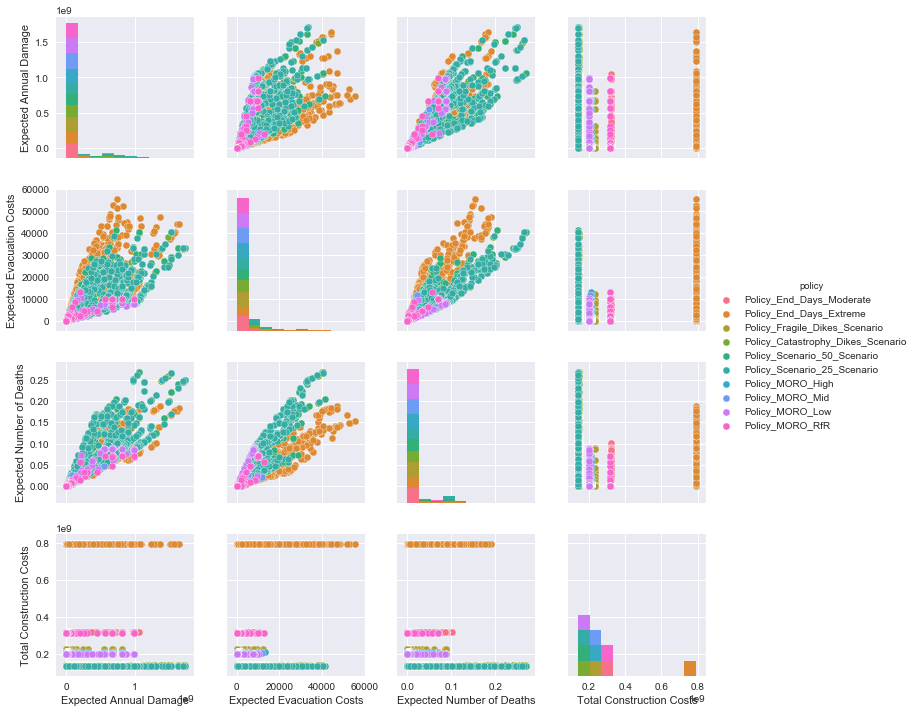

In [6]:
experiments, outcomes = results
dfexperiment = pd.DataFrame(data=experiments)
dfoutput = pd.DataFrame(data=outcomes)

dfoutput['policy'] = dfexperiment['policy']

sns.pairplot(dfoutput, hue='policy',  vars=dfoutput.columns.drop('policy'), )

plt.show()

In [13]:
dfoutput.to_csv("dfoutput.csv", index=False)
dfexperiment.to_csv("dfexperiment.csv", index=False)

In [12]:
df_moro_results_mean = dfoutput.groupby(['policy']).mean()
df_moro_results_mean.sort_values('Expected Number of Deaths')

# df_moro_results_max = dfoutput.groupby(['policy']).max()
# df_moro_results_max.sort_values('Expected Number of Deaths')

,Expected Annual Damage,Expected Evacuation Costs,Expected Number of Deaths,Total Construction Costs
policy,,,,
Policy_MORO_Mid,2.572447e+06,86.955770,0.000310,2.070158e+08
Policy_MORO_High,2.844370e+06,104.664298,0.000389,2.132707e+08
Policy_Fragile_Dikes_Scenario,3.072519e+06,101.236348,0.000437,2.301271e+08
Policy_MORO_RfR,5.896436e+06,172.503191,0.000610,3.158003e+08
Policy_MORO_Low,1.117033e+07,178.318172,0.001462,1.999720e+08
Policy_End_Days_Moderate,2.206300e+07,261.417401,0.002678,3.183292e+08
Policy_Catastrophy_Dikes_Scenario,1.726331e+08,3796.896906,0.025637,1.422206e+08
Policy_Scenario_50_Scenario,1.787060e+08,4121.524660,0.026610,1.388276e+08
Policy_End_Days_Extreme,1.703204e+08,8655.329291,0.028129,7.918116e+08
